# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, MaxPooling2D, 
                                     AveragePooling2D, GlobalAveragePooling2D)
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from PIL import Image

### Загрузим данные

In [2]:
labels = pd.read_csv('labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,Unnamed: 0,file_name,real_age
0,0,000000.jpg,4
1,1,000001.jpg,18
2,2,000002.jpg,80
3,3,000003.jpg,50
4,4,000004.jpg,17


### Посмотрим на размер выборки

In [4]:
labels.shape

(7591, 3)

### Построим график распределения возраста в выборке.

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Максимальный возраст 100 лет, построим гистограмму со 100 корзинами.

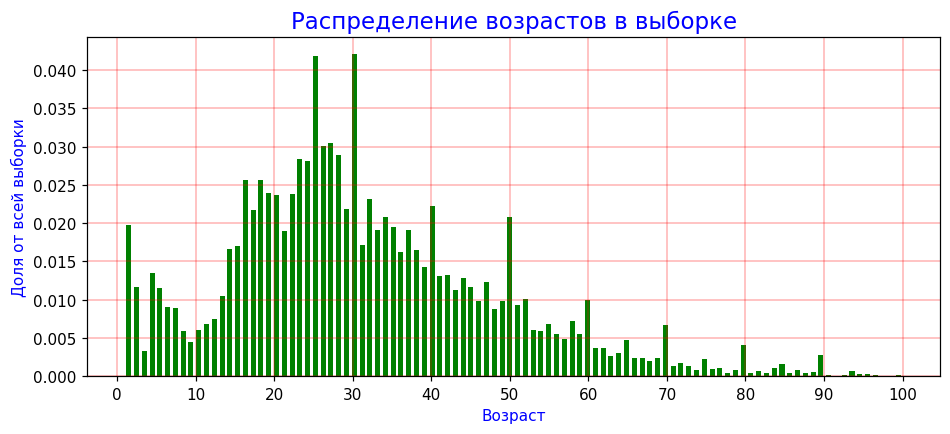

In [7]:
plt.figure(figsize=(10, 4), dpi=110)
plt.hist(labels['real_age'], bins=100, density=True, rwidth=0.65, color='g')
plt.grid(visible=True, color='r', linewidth=0.3)
plt.xticks(range(0, 101, 10))
plt.xlabel('Возраст', color='b')
plt.ylabel('Доля от всей выборки', color='b')
plt.title('Распределение возрастов в выборке', color='b', fontsize=15);

Чаще всего в выборке встречаются возрасты от 20 до 30 лет.

### Напечатаем фотографии

Напечатаем 16 фотографий и подпишем возраст люджей на них.

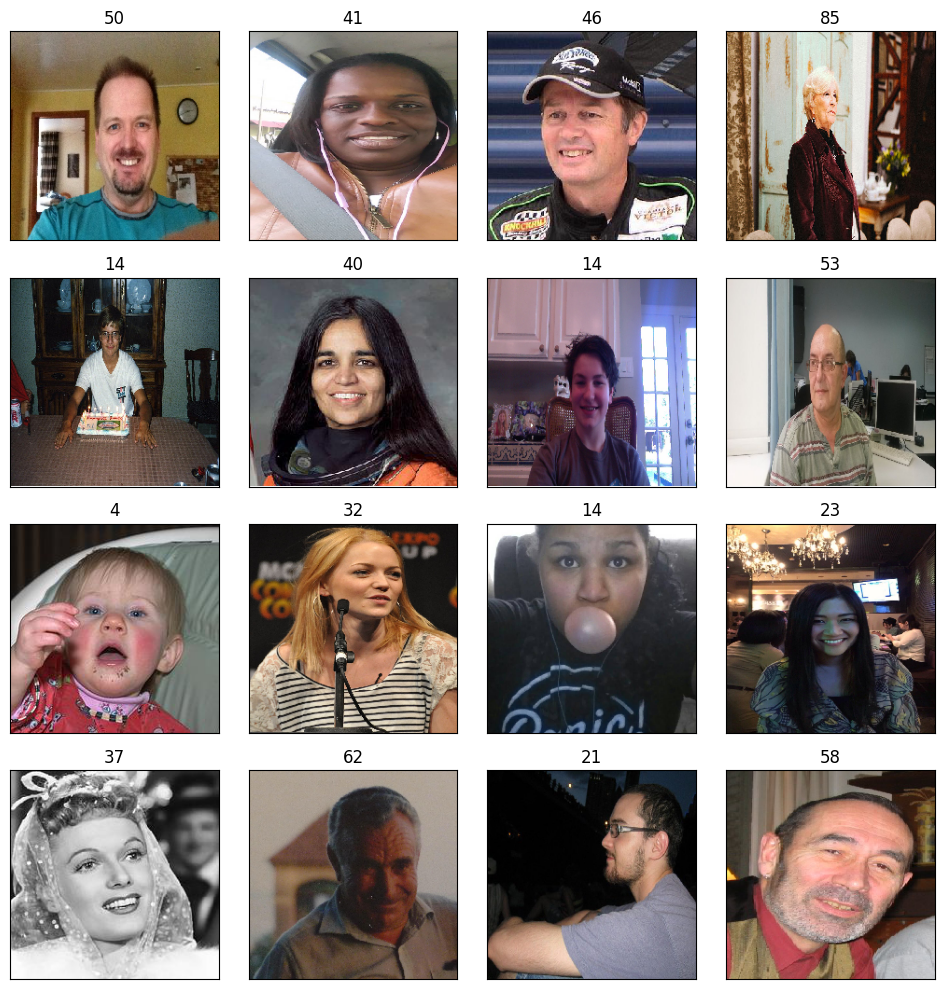

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(gen_flow[0][0][i])
    plt.title(gen_flow[0][1][i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Визуально возраст соответствует возрасту людей на фотографиях.

### Вывод

В результате исследовательский анализ данных мы пришли к выводу:
   - Данных мало. На каждый возраст в среднем приходится 77 фотографий (7591 / 99), некоторые возрасты представлены еще хуже. Необходимо применение аугментации. Попробуем использовать смещение, повороты и зум.
   - В датасете присутствуют возрасты от 1 до 100 лет. Количесвто объектов разных возрастов не одинаковое. Больше всего фотографий людей в возрасте от 20 до 30 лет. Возможно люди в возрасте от 20 до 30 лет будут определяться точнее, чем люди в возрасте от 60 до 100 лет. 
   - На гистограмме наблюдаются всплески количества фото в юбилейные годы, что может свидетельствовать о не очень качественной разметке части данных. Возможно возраст людей на этих фотографиях округлен.
   - Так же видно, что на части фотографий аугментация уже была проведена (повороты, смещениея, зум и тд)
   - Присутствуют и ч/б фотографии.
   - Посторонние предметы, такие как жувачки, очки, микрафоны и тд тоже усложнят/ухудшат работу модели.

## Обучение модели

(Код в этом разделе запускается на отдельном GPU сервере, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 

optimizer = Adam(lr=0.0005)

labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True, 
    vertical_flip=True,
    width_shift_range=.2,
    height_shift_range=.2
    )

def load_train(path):
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='training')
    return train_datagen_flow

def load_test(path):
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation')
    return test_datagen_flow


def create_model(input_shape):
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer=optimizer, 
                  metrics=['mean_absolute_error'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15, 
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/80
2023-03-04 10:54:45.289003: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-04 10:54:45.695696: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 120s - loss: 292.8935 - mean_absolute_error: 12.5817 - val_loss: 618.6975 - val_mean_absolute_error: 19.8777
Epoch 2/80
178/178 - 119s - loss: 130.2970 - mean_absolute_error: 8.6894 - val_loss: 652.8355 - val_mean_absolute_error: 20.5504
Epoch 3/80
178/178 - 113s - loss: 110.7139 - mean_absolute_error: 7.9511 - val_loss: 554.4080 - val_mean_absolute_error: 18.2480
Epoch 4/80
178/178 - 121s - loss: 98.5714 - mean_absolute_error: 7.5548 - val_loss: 182.8318 - val_mean_absolute_error: 10.1892
Epoch 5/80
Epoch 6/80
178/178 - 113s - loss: 90.4681 - mean_absolute_error: 7.2245 - val_loss: 120.1592 - val_mean_absolute_error: 8.2638
178/178 - 109s - loss: 79.6444 - mean_absolute_error: 6.7947 - val_loss: 106.2285 - val_mean_absolute_error: 7.6399
Epoch 7/80
178/178 - 107s - loss: 80.4842 - mean_absolute_error: 6.8554 - val_loss: 113.8201 - val_mean_absolute_error: 8.3419
Epoch 8/80
178/178 - 108s - loss: 73.8004 - mean_absolute_error: 6.5387 - val_loss: 100.2984 - val_mean_absolute_error: 7.6218
Epoch 9/80
178/178 - 108s - loss: 67.6281 - mean_absolute_error: 6.2836 - val_loss: 101.5967 - val_mean_absolute_error: 7.4459
Epoch 10/80
178/178 - 108s - loss: 64.6638 - mean_absolute_error: 6.1190 - val_loss: 103.1415 - val_mean_absolute_error: 7.5168
Epoch 11/80
178/178 - 114s - loss: 59.4239 - mean_absolute_error: 5.8798 - val_loss: 138.1519 - val_mean_absolute_error: 8.3756
Epoch 12/80
178/178 - 113s - loss: 62.3359 - mean_absolute_error: 5.9837 - val_loss: 102.5681 - val_mean_absolute_error: 7.7073
Epoch 13/80
178/178 - 122s - loss: 54.8065 - mean_absolute_error: 5.7095 - val_loss: 101.2271 - val_mean_absolute_error: 7.5657
Epoch 14/80
178/178 - 123s - loss: 48.7721 - mean_absolute_error: 5.3641 - val_loss: 95.4705 - val_mean_absolute_error: 7.1668
Epoch 15/80
178/178 - 124s - loss: 45.6310 - mean_absolute_error: 5.2041 - val_loss: 91.3990 - val_mean_absolute_error: 7.1638
Epoch 16/80
178/178 - 125s - loss: 44.0776 - mean_absolute_error: 5.0997 - val_loss: 95.8624 - val_mean_absolute_error: 7.0168
Epoch 17/80
178/178 - 126s - loss: 43.1660 - mean_absolute_error: 5.0600 - val_loss: 95.9544 - val_mean_absolute_error: 7.2629
Epoch 18/80
178/178 - 110s - loss: 40.4081 - mean_absolute_error: 4.9034 - val_loss: 101.7053 - val_mean_absolute_error: 7.8859
Epoch 19/80
178/178 - 118s - loss: 37.1298 - mean_absolute_error: 4.6544 - val_loss: 111.9581 - val_mean_absolute_error: 7.6028
Epoch 20/80
178/178 - 125s - loss: 38.3619 - mean_absolute_error: 4.7880 - val_loss: 91.6462 - val_mean_absolute_error: 7.0414
Epoch 21/80
178/178 - 124s - loss: 36.3193 - mean_absolute_error: 4.6176 - val_loss: 83.1253 - val_mean_absolute_error: 6.7687
Epoch 22/80
178/178 - 125s - loss: 35.6518 - mean_absolute_error: 4.5811 - val_loss: 135.0192 - val_mean_absolute_error: 8.7345
Epoch 23/80
178/178 - 121s - loss: 33.9421 - mean_absolute_error: 4.4887 - val_loss: 102.9778 - val_mean_absolute_error: 7.4539
Epoch 24/80
178/178 - 110s - loss: 33.0050 - mean_absolute_error: 4.4158 - val_loss: 96.1816 - val_mean_absolute_error: 7.2037
Epoch 25/80
178/178 - 113s - loss: 30.5732 - mean_absolute_error: 4.2408 - val_loss: 91.1570 - val_mean_absolute_error: 7.1602
Epoch 26/80
178/178 - 123s - loss: 29.3277 - mean_absolute_error: 4.1615 - val_loss: 100.2266 - val_mean_absolute_error: 7.2074
Epoch 27/80
178/178 - 125s - loss: 28.0266 - mean_absolute_error: 4.0686 - val_loss: 80.6910 - val_mean_absolute_error: 6.7010
Epoch 28/80
178/178 - 125s - loss: 28.6403 - mean_absolute_error: 4.1067 - val_loss: 89.8541 - val_mean_absolute_error: 7.2130
Epoch 29/80
178/178 - 125s - loss: 26.2004 - mean_absolute_error: 3.9527 - val_loss: 83.7300 - val_mean_absolute_error: 6.6185
Epoch 30/80
178/178 - 124s - loss: 27.5333 - mean_absolute_error: 3.9928 - val_loss: 79.6364 - val_mean_absolute_error: 6.6383
Epoch 31/80
178/178 - 121s - loss: 25.2925 - mean_absolute_error: 3.8651 - val_loss: 83.4039 - val_mean_absolute_error: 6.6940
Epoch 32/80
178/178 - 111s - loss: 23.5459 - mean_absolute_error: 3.7556 - val_loss: 75.9772 - val_mean_absolute_error: 6.4994
Epoch 33/80
178/178 - 126s - loss: 22.2183 - mean_absolute_error: 3.6387 - val_loss: 77.8797 - val_mean_absolute_error: 6.4805
Epoch 34/80
178/178 - 126s - loss: 21.9426 - mean_absolute_error: 3.5974 - val_loss: 78.0694 - val_mean_absolute_error: 6.7053
Epoch 35/80
178/178 - 126s - loss: 21.2037 - mean_absolute_error: 3.5106 - val_loss: 90.0503 - val_mean_absolute_error: 7.3269
Epoch 36/80
178/178 - 127s - loss: 20.5222 - mean_absolute_error: 3.4802 - val_loss: 79.5325 - val_mean_absolute_error: 6.5289
Epoch 37/80
178/178 - 123s - loss: 22.3036 - mean_absolute_error: 3.6165 - val_loss: 100.1305 - val_mean_absolute_error: 7.2306
Epoch 38/80
178/178 - 113s - loss: 21.1328 - mean_absolute_error: 3.4660 - val_loss: 82.5976 - val_mean_absolute_error: 6.7543
Epoch 39/80
178/178 - 116s - loss: 22.4832 - mean_absolute_error: 3.6024 - val_loss: 78.3477 - val_mean_absolute_error: 6.6098
Epoch 40/80
178/178 - 113s - loss: 20.2604 - mean_absolute_error: 3.4641 - val_loss: 87.8328 - val_mean_absolute_error: 6.8830
Epoch 41/80
178/178 - 108s - loss: 21.3016 - mean_absolute_error: 3.5467 - val_loss: 84.1919 - val_mean_absolute_error: 6.8168
Epoch 42/80
Epoch 43/80
178/178 - 107s - loss: 18.0782 - mean_absolute_error: 3.2598 - val_loss: 76.2921 - val_mean_absolute_error: 6.4919
178/178 - 108s - loss: 17.5917 - mean_absolute_error: 3.2070 - val_loss: 92.7499 - val_mean_absolute_error: 6.8679
Epoch 44/80
178/178 - 107s - loss: 16.9924 - mean_absolute_error: 3.1680 - val_loss: 79.7241 - val_mean_absolute_error: 6.6562
Epoch 45/80
178/178 - 108s - loss: 16.8010 - mean_absolute_error: 3.1628 - val_loss: 86.6720 - val_mean_absolute_error: 6.7615
Epoch 46/80
178/178 - 107s - loss: 15.8536 - mean_absolute_error: 3.0439 - val_loss: 75.6615 - val_mean_absolute_error: 6.5245
Epoch 47/80
178/178 - 108s - loss: 28.9761 - mean_absolute_error: 3.9776 - val_loss: 95.4728 - val_mean_absolute_error: 7.2289
Epoch 48/80
178/178 - 108s - loss: 23.7022 - mean_absolute_error: 3.6926 - val_loss: 84.0292 - val_mean_absolute_error: 6.7228
Epoch 49/80
178/178 - 109s - loss: 17.8706 - mean_absolute_error: 3.2295 - val_loss: 83.3003 - val_mean_absolute_error: 6.7513
Epoch 50/80
178/178 - 107s - loss: 16.7509 - mean_absolute_error: 3.1609 - val_loss: 86.2864 - val_mean_absolute_error: 6.8879
Epoch 51/80
178/178 - 107s - loss: 15.3657 - mean_absolute_error: 3.0110 - val_loss: 78.7286 - val_mean_absolute_error: 6.4337

```

## Анализ обученной модели

Обученная модель основана на модели ResNet50. 
Добавлены 2 слоя GlobalAveragePooling2D и полносвязный слой из одного нейрона (тк решалась задача регрессии). 

Размер батча - 32 фотграфии
Количество эпох - 80
Начальный learning rate оптимизатора Adam - 0,0001

## Выводы

Были проанализирован доступный набор фотографий с размечеными возрастами. Разметка оказалась адекватной. В наборе 7591 фотографий людей в возрасте от 1 до 100 лет. Больше всего людей в возрасте от 20 до 30 лет. 
На основании имеющихся фотографий и размеченых возрастов были созданы 2 выборки train и validation.
Данные выборки использовались для обучения и проверки модели. Модель была создана на базе ResNet50.
Итоговая метрика модели MAE 6.4337